## Modeling

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import loguniform
from sklearn.metrics import (roc_auc_score, precision_score,
                             recall_score, f1_score,fbeta_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,roc_curve, confusion_matrix
import xgboost as xgb

C:\Users\Julia\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [3]:
X_train = pd.read_csv('../Data/X_train.csv',index_col=0)
X_test = pd.read_csv('../Data/X_test.csv',index_col=0)
y_train = pd.read_csv('../Data/y_train.csv',index_col=0)
y_test = pd.read_csv('../Data/y_test.csv',index_col=0)

In [4]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [5]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [6]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3019, 22), (1294, 22), (3019,), (1294,))

### StratifiedKFold cross-validator ensures that each fold of the dataset has the same proportion of observations with a given label, therefore it appropriate to use it for this imbalanced dataset.

In [7]:
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

## Logistic regression

In [8]:
lr_parameters = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'C':[100, 10, 1.0, 0.1, 0.01],
             'penalty':['none', 'l1', 'l2', 'elasticnet']}

In [9]:
lr_model = LogisticRegression()
lr_clf = GridSearchCV(lr_model, param_grid = lr_parameters,cv=cv,scoring='roc_auc')

In [9]:
#lr_clf.fit(X_train, y_train)

In [17]:
#print('The best score is', lr_clf.best_score_,'with following best parameters',lr_clf.best_params_)

The best score is 0.7939334165696043 with following best parameters {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


In [90]:
lr_model = LogisticRegression(C=10, penalty='elasticnet', 
                              solver='saga',l1_ratio = 0.1,random_state=50,
                             ).fit(X_train,y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]
y_pred = lr_model.predict(X_test)

In [91]:
print(f'Logistic Regression\n')
roc = roc_auc_score(y_test, lr_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, y_pred,zero_division=0))

Logistic Regression

ROC AUC: 0.8
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1212
           1       0.33      0.01      0.02        82

    accuracy                           0.94      1294
   macro avg       0.64      0.51      0.50      1294
weighted avg       0.90      0.94      0.91      1294



In [92]:
print(classification_report(y_test,lr_probs > .05))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1212
           1       0.14      0.83      0.24        82

    accuracy                           0.66      1294
   macro avg       0.56      0.74      0.51      1294
weighted avg       0.93      0.66      0.75      1294



In [93]:
cf_matrix = confusion_matrix(y_test,y_pred)

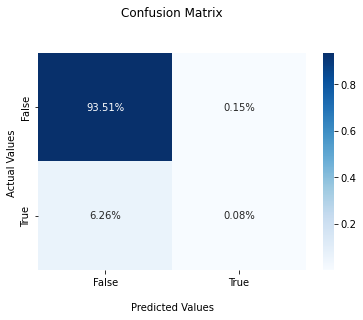

In [94]:
ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [96]:
 from sklearn.metrics import brier_score_loss

In [98]:
brier_score_loss(y_test, lr_probs,pos_label=1)

0.05555197209244967

### Random Forest Classifier

In [99]:
parameters_rf = {'n_estimators' : [10, 100, 200, 500, 1000], 
                'max_features' : ['auto','sqrt', 'log2'],
                'criterion':['gini', 'entropy', 'log_loss'],
                'max_depth': [10, 20, 30, 40, 50]}

In [100]:
rf_model = RandomForestClassifier()
rf_clf = GridSearchCV(rf_model, param_grid = parameters_rf,cv=cv,scoring='roc_auc')

In [36]:
#rf_clf.fit(X_train, y_train)

In [27]:
#print('The best score is', rf_clf.best_score_,'with following best parameters',rf_clf.best_params_)

The best score is 0.7584461073077536 with following best parameters {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}


In [156]:
rf_model = RandomForestClassifier(criterion='entropy',max_depth=10,
                                  max_features='sqrt',n_estimators=1000,
                                  random_state=50)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_preds = rf_model.predict(X_test)

In [157]:
print(f'Random Forest Classifier\n')
roc = roc_auc_score(y_test, rf_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, rf_preds,zero_division=0))

Random Forest Classifier

ROC AUC: 0.7805
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1212
           1       0.25      0.01      0.02        82

    accuracy                           0.94      1294
   macro avg       0.59      0.50      0.49      1294
weighted avg       0.89      0.94      0.91      1294



In [158]:
cf_matrix = confusion_matrix(y_test,rf_preds)

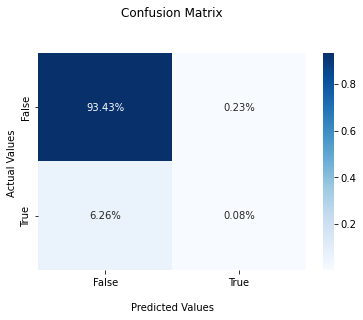

In [159]:
ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### XGBoost

In [160]:
xgb_parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
               'max_depth' : [1,3,4,8,16],
               'min_child_weight' : [1,4,5,8,10],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8,1.0],
               'n_estimators' : [200,400,800,1600,6400],
               'reg_alpha' : np.arange(0.001, 10, 1) }

In [161]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_clf = GridSearchCV(xgb_model, param_grid = xgb_parameters,cv=cv,scoring='roc_auc')

In [2]:
#xgb_clf.fit(X_train,y_train)

In [40]:
#print('The best score is', xgb_clf.best_score_,'with following best parameters',xgb_clf.best_params_)

The best score is nan with following best parameters {'colsample_bytree': 0.6, 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.001, 'subsample': 0.6}


In [170]:
xgb_model = xgb.XGBClassifier(objective= 'binary:logistic',colsample_bytree= 0.6,
                              learning_rate=0.0001,n_estimators=200,
                              reg_alpha=0.001,max_depth = 1,min_child_weight=1,
                              subsample=0.6, use_label_encoder=False, 
                            seed=42, verbosity=0)

In [171]:
def replace_char(df):
    df.columns = df.columns.str.replace("_", "")
    df.columns = df.columns.str.replace(",", "")
    df.columns = df.columns.str.replace("]", "")
    df.columns = df.columns.str.replace("[", "")

In [172]:
replace_char(X_train)
replace_char(X_test)

In [173]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0001, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0.001, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [174]:
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_preds = xgb_model.predict(X_test)

In [175]:
print(f'XGBoost Classifier\n')
roc = roc_auc_score(y_test, xgb_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, xgb_preds,zero_division=0))

XGBoost Classifier

ROC AUC: 0.7862
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1212
           1       0.00      0.00      0.00        82

    accuracy                           0.94      1294
   macro avg       0.47      0.50      0.48      1294
weighted avg       0.88      0.94      0.91      1294



In [176]:
cf_matrix = confusion_matrix(y_test,xgb_preds)

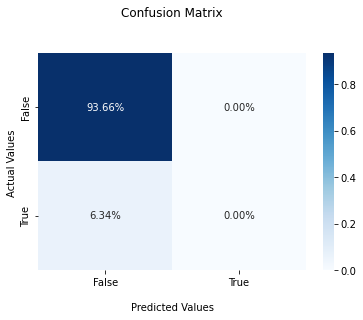

In [177]:
ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## scale_pos_weight is used to control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)

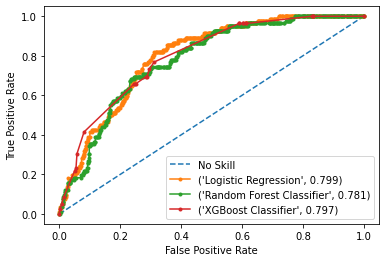

In [51]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.',label=('Logistic Regression',round(lr_auc,3)))
plt.plot(rf_fpr, rf_tpr, marker='.',label=('Random Forest Classifier',round(rf_auc,3)))
plt.plot(xgb_fpr, xgb_tpr, marker='.',label=('XGBoost Classifier',round(xgb_auc,3)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

### Logistic regression has the highers ROC-AUC score

### Calculating presicion-recall based on different beta thresholds

In [75]:
def thr(threshold):
    y_pred = (lr_model.predict_proba(X_test)[:,1] >= threshold)
    p = precision_score(y_test,y_pred)
    r = recall_score(y_test,y_pred)
    f = fbeta_score(y_test, y_pred,beta=0.5)
    return p,r,f

In [76]:
thr_dict = {}
for threshold in sorted(list(set(lr_model.predict_proba(X_test)[:,1]))):
    p,r,f = thr(threshold)
    thr_dict[threshold] = p,r,f

In [77]:
thr_dict

{5.526008667779071e-06: (0.0633693972179289, 1.0, 0.07797641688855078),
 9.522746007581733e-06: (0.0634184068058778, 1.0, 0.07803578226113438),
 1.012456845353886e-05: (0.06351665375677769, 1.0, 0.07815478459778878),
 1.3915056884348343e-05: (0.06356589147286822, 1.0, 0.0782144219763449),
 6.56143585617517e-05: (0.06361520558572537, 1.0, 0.07827415043909888),
 6.976083467020029e-05: (0.06371406371406371, 1.0, 0.07839388145315489),
 7.066959269155932e-05: (0.06376360808709176, 1.0, 0.07845388442403368),
 7.134812876363011e-05: (0.06381322957198443, 1.0, 0.07851397931826887),
 7.290065721673645e-05: (0.06386292834890965, 1.0, 0.07857416634725947),
 7.411166487377975e-05: (0.06391270459859703, 1.0, 0.07863444572305331),
 7.51355085225312e-05: (0.06401249024199844, 1.0, 0.0787552823665002),
 7.750755269232302e-05: (0.0640625, 1.0, 0.07881584006151479),
 7.844448213691246e-05: (0.06426332288401254, 1.0, 0.07905900501349789),
 8.09209828616043e-05: (0.06431372549019608, 1.0, 0.07912003087610

In [78]:
res = pd.DataFrame.from_dict(thr_dict).T.rename(columns={"index": "Threshold", 0: "Precision",
                                                                              1: "Recall",2:'F_beta'})

In [79]:
res

,Precision,Recall,F_beta
0.000006,0.063369,1.000000,0.077976
0.000010,0.063418,1.000000,0.078036
0.000010,0.063517,1.000000,0.078155
0.000014,0.063566,1.000000,0.078214
0.000066,0.063615,1.000000,0.078274
...,...,...,...
0.441606,0.400000,0.024390,0.098039
0.490207,0.500000,0.024390,0.102041
0.515079,0.333333,0.012195,0.053191
0.525808,0.500000,0.012195,0.055556


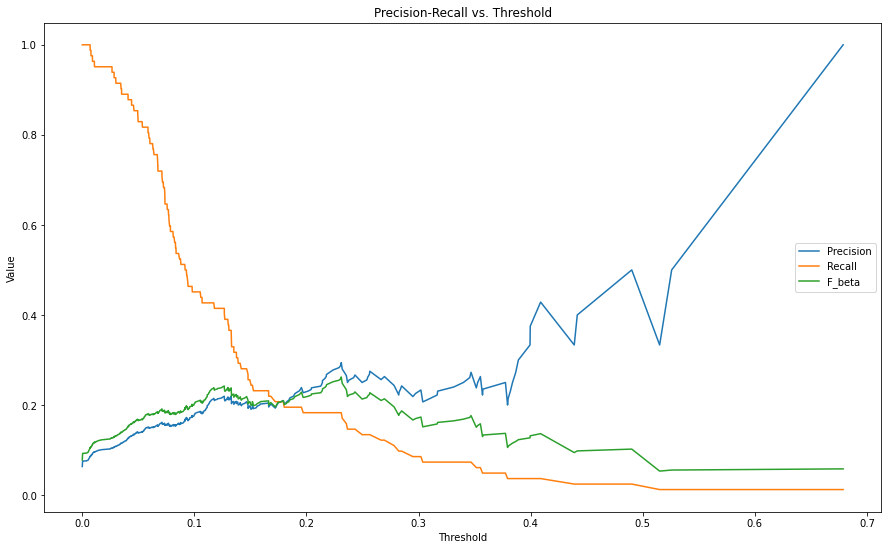

In [80]:
ax = res.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.set_title('Precision-Recall vs. Threshold');
